In [40]:
import itertools
import copy
import numpy as np
import matplotlib.pyplot as plt
import torch
from torch.utils.data import Dataset, DataLoader, random_split
import torch.nn as nn
import pickle
import random
from sklearn.model_selection import train_test_split
import time
from joblib import Parallel, delayed
import pandas as pd
import sys
import os
import seaborn as sns 
from sklearn.metrics import r2_score
import math
import matplotlib as mpl
from sklearn.manifold import MDS
from sklearn.metrics.pairwise import manhattan_distances, euclidean_distances
import scipy

from cryptic_rnn import *

In [41]:
ops = '-'

num_inputs = 4
total_syms = ['A','B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P']
all_syms = total_syms[:num_inputs]
all_input_vals = list(np.arange(2,18))
input_vals = random.sample(all_input_vals,num_inputs)
input_vals.sort()
# randomly select values for each input
cue_dict = {}
for i, s in enumerate(all_syms):
    cue_dict[s] = input_vals[i]
    
print(cue_dict)
primitives = generate_primitives(all_syms, cue_dict)
rp = generate_other_reverse_primitives('+', all_syms, cue_dict)
print(primitives)
print(rp)
testseqs = generate_trials(ops, all_syms, all_syms, cue_dict)

{'A': 2, 'B': 8, 'C': 14, 'D': 17}
[['A', '=', 2], ['B', '=', 8], ['C', '=', 14], ['D', '=', 17]]
[['A', ('+', 'C'), '=', 16], ['B', ('+', 'D'), '=', 25]]


In [42]:
# data
num_classes = 22
batchsize=1

# RNN specs
input_size = num_classes
output_size = 1
num_layers = 1
hidden_size = 20
learningRate = 0.005

## running params
epochs = 1200
num_sims = 104

In [66]:
## running function
def get_reps(model, testdata, hidden_size):
    model.eval()
    trials = []
    hiddens = []
    for testset in testdata:
        for x,y in testset:
            for i in range(len(x)):
                hidden_arr = np.empty((0,  hidden_size))
                hidden = torch.zeros(1, hidden_size)[0]
                for step in x[i]:
                    hidden, y_hat = model.get_activations(step,hidden)
                    hidden_arr = np.vstack([hidden_arr, hidden.detach().numpy()])
            hiddens.append(hidden_arr)
            trials.append(str(onehot2seq(x)))

    return hiddens, trials 


## calculate distance matrices for all models and steps 
 

def calculate_RDMs(res):
    ## find indices of 100% acc rnns
    acc_df = res['acc_df']
    #all_acc_mods = acc_df[acc_df['acc_train'] == 1].index
    all_acc_mods = acc_df.index
    print('no. 100% trained RNNs: ', len(all_acc_mods))

    mod_list = all_acc_mods # choose only rnns trained to 100%
    #mod_list = np.arange(num_sims)

    # initialise empty lists/arrays
    rdms = [[] for _ in range(4)]

    # extracts results from dictionary
    mods = res['mods']
    cue_dicts = res['cue_dicts']
    testseq = generate_trials(ops, all_syms, all_syms, cue_dict)
    ft_cue_dicts = [cue_dicts[j] for j in mod_list]

    for ind, m in enumerate(mod_list): # for each model 
        
        testseqs = change_dict(testseq, cue_dicts[m])
        train_inputs = convert_seq2inputs(testseq, num_classes=num_classes, seq_len=5)
        testset = DataLoader(train_inputs, batch_size=batchsize, shuffle=False)
        
        # get activations for control model
        hiddens, trials = get_reps(mods[m], [testset], hidden_size)
        for h in range(4): 
            hid_vals = np.array([hid[h,:] for hid in hiddens]) # combine activations from each trial for the time step
            rep_mat = euclidean_distances(hid_vals) # calculate euclidean distance matrix between trials
            rdms[h].append(rep_mat)
            
    return {'rdms': rdms, 'ft_cue_dicts': ft_cue_dicts}


# for ranked control
rank_dict = {'A': -1.5, 'B': -0.5, 'C': 0.5, 'D': 1.5}

# for selecting untrained trials
rp = generate_other(ops, all_syms, cue_dict) + generate_other_reverse_primitives('+', all_syms, cue_dict)
valset = [t for t in testseqs if t not in rp]
valset_idx = [testseqs.index(val) for val in valset]

def regress_RDM_abs(time_step, rdm, ft_cue_dicts, ranked = False):
    rs = []
    for i, cuedict in enumerate(ft_cue_dicts):
        if ranked:
            curr_tests = change_dict(testseqs, rank_dict)
        else:
            curr_tests = change_dict(testseqs, cuedict)
        truth_outs = [t[-1] for t in curr_tests]
        truth_RDM = abs(np.array([truth_outs]*16) - np.array([truth_outs]*16).T)
        x = []
        y = []
        for p in valset_idx:
            for q in valset_idx:
                x.append(rdm[time_step][i][p,q])
                y.append(truth_RDM[p,q])
        x = np.array(x).reshape(-1,1)
        y = np.array(y)
        model = LinearRegression().fit(x, y)
        r_sq = model.score(x, y)
        rs.append(r_sq)
    return rs


In [44]:
def truth_RDM_init(rdm, ft_cue_dicts, ranked = False):
    rs = []
    for i, cuedict in enumerate(ft_cue_dicts):
        if ranked:
            curr_tests = change_dict(testseqs, rank_dict)
        else:
            curr_tests = change_dict(testseqs, cuedict)
        init_tests = [[t[0]]+['='] for t in curr_tests ]
        truth_outs = [calculate_output(t, cuedict) for t in init_tests]
        truth_RDM = abs(np.array([truth_outs]*16) - np.array([truth_outs]*16).T)
        rs.append(truth_RDM)
    return rs

def truth_RDM(rdm, ft_cue_dicts, ranked = False):
    rs = []
    for i, cuedict in enumerate(ft_cue_dicts):
        if ranked:
            curr_tests = change_dict(testseqs, rank_dict)
        else:
            curr_tests = change_dict(testseqs, cuedict)
        truth_outs = [t[-1] for t in curr_tests]
        truth_RDM = abs(np.array([truth_outs]*16) - np.array([truth_outs]*16).T)
        rs.append(truth_RDM)
    return rs


In [56]:
hidden_size=8

# Read data

In [51]:
# read data

save_dir = '../results/representation_analysis/'

with open(save_dir+'res_sub', 'rb') as f:
    res1 = pickle.load(f)

## Other

In [67]:
res = calculate_RDMs(res1)
rdms = res['rdms']
cue_dicts = res['ft_cue_dicts']

matlist = [np.array(rdms[t]).mean(axis=0) for t in range(4)]
truth_list = [np.array(truth_RDM(t, rdms, cue_dicts)).mean(axis=0) for t in range(4)]

no. 100% trained RNNs:  64


In [68]:
# find indices of untrained trials
rp = generate_other(ops, all_syms, cue_dict) + generate_primitives(all_syms, cue_dict)
valset = [t for t in testseqs if t not in rp]
valset_idx = [testseqs.index(val) for val in valset]

In [69]:
from sklearn.decomposition import PCA
pca = PCA(n_components=3)
pca.fit(matlist[3])
print('no prims:   ', pca.explained_variance_ratio_)


no prims:    [0.8469884  0.09858193 0.03291639]


In [70]:
colors2 = ['green', 'blue', 'orange', 'red']*4
colors1 = ['green']*4 + ['blue']*4 + ['orange']*4 + [ 'red']*4

In [71]:
from matplotlib.lines import Line2D

legend_elements = [Line2D([0], [0], marker='o', color='w', markerfacecolor='green', markersize=5, label='A + _'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='blue', markersize=5, label='B + _'), 
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='orange', markersize=5, label='C + _'),
                   Line2D([0], [0], marker='o', color='w', markerfacecolor='red', markersize=5, label='D + _'),
                   Line2D([0], [0], marker='o', color='w', markeredgecolor = 'green', markerfacecolor='none', markersize=10, label=' _ + A'),
                   Line2D([0], [0], marker='o', color='w', markeredgecolor = 'blue',markerfacecolor='none', markersize=10, label=' _ + B'), 
                   Line2D([0], [0], marker='o', color='w', markeredgecolor = 'orange',markerfacecolor='none', markersize=10, label=' _ + C'),
                   Line2D([0], [0], marker='o', color='w', markeredgecolor = 'red',markerfacecolor='none', markersize=10, label=' _ + D')]


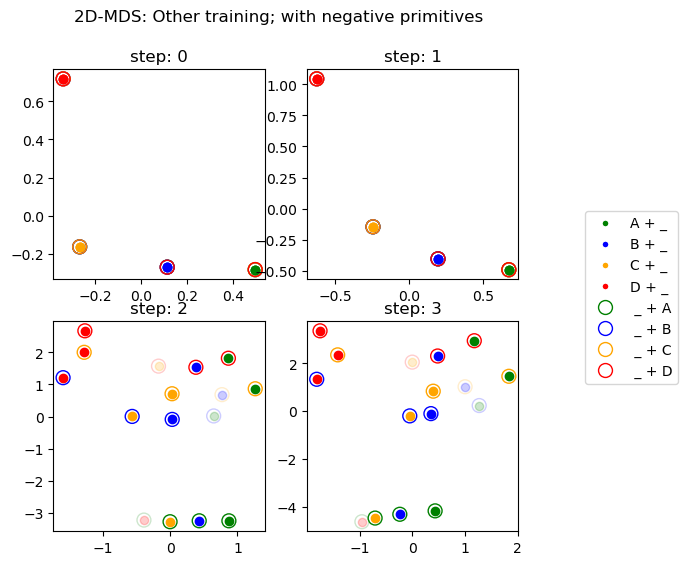

In [72]:
plt.rcParams['figure.figsize'] = 6, 6
fig, axs = plt.subplots(2,2)

#matlist = [rdms[t][m] for t in range(4)]
for j, dist in enumerate(matlist):
    mds = MDS(dissimilarity='precomputed',random_state=0, n_components=2)
    X_transform = mds.fit_transform(dist)
    ax = axs[math.floor(j/2), j%2]
    ax.title.set_text('step: '+str(j))
    for i in range(len(testseqs)):
        if i in valset_idx:
            alph = 1
        else:
            alph = 0.2
        ax.scatter(X_transform[i,0], X_transform[i,1], color = colors1[i], alpha = alph)
        ax.scatter(X_transform[i,0], X_transform[i,1], s=100, facecolors='none', edgecolors=colors2[i], alpha = alph)

plt.suptitle('2D-MDS: Other training; with negative primitives')

fig.legend(handles=legend_elements,  loc='center left', bbox_to_anchor=(1, 0.5))